# Beta-Binomial Distribution with NGBoost

**Problem**: Count regression with overdispersion. The Beta-Binomial models
the number of successes in `n` trials where the success probability itself
follows a Beta(alpha, beta) prior, producing greater variance than a plain
Binomial.

**When to use**:
- Quality control: number of defective items per batch when defect rate varies
- Clinical trials: number of responders out of n patients with uncertain response rate
- Sports analytics: number of wins in n games with uncertain win probability
- Survey data: number of "yes" responses out of n respondents per group

**How it differs from Binomial**: The Binomial assumes a fixed probability `p`.
The Beta-Binomial assumes `p` itself is uncertain (Beta-distributed), leading
to overdispersion — more variance than the Binomial alone would predict.

**What this notebook shows**: The **extra non-optimized parameter** pattern —
`n` (number of trials) is fixed per dataset, not learned by NGBoost. Uses
`make_sympy_log_score` with a manual score expression and `extra_params=[n]`.

In [1]:
import sys
sys.path.insert(0, '..')  # add project root so 'import ngboost' finds the package

In [ ]:
import numpy as np
import sympy as sp
import scipy.stats
from sklearn.model_selection import train_test_split

from ngboost import NGBRegressor
from ngboost.distns.distn import RegressionDistn
from ngboost.distns.sympy_utils import make_sympy_log_score

## 1. Define the score class

There is no `sympy.stats.BetaBinomial`, so we write the negative
log-likelihood manually using loggamma functions. The parameter `n`
(number of trials) is passed as an `extra_param` — it appears in the
score but is **not** optimized by NGBoost.

In [3]:
alpha, beta = sp.symbols("alpha beta", positive=True)
y, n = sp.symbols("y n", positive=True, integer=True)

score_expr = -(
    sp.loggamma(n + 1) - sp.loggamma(y + 1) - sp.loggamma(n - y + 1)
    + sp.loggamma(y + alpha) + sp.loggamma(n - y + beta)
    - sp.loggamma(n + alpha + beta)
    + sp.loggamma(alpha + beta)
    - sp.loggamma(alpha) - sp.loggamma(beta)
)

BetaBinomialLogScore = make_sympy_log_score(
    params=[(alpha, True), (beta, True)],
    y=y,
    score_expr=score_expr,
    extra_params=[n],
    name="BetaBinomialLogScore",
)

print(f"Score class: {BetaBinomialLogScore}")
print(f"  Has analytical metric: {'metric' in BetaBinomialLogScore.__dict__}")

Score class: <class 'ngboost.distns.sympy_utils.BetaBinomialLogScore'>
  Has analytical metric: False


## 2. Build the regression distribution

Since BetaBinomial has the extra parameter `n`, we write a thin
`RegressionDistn` wrapper. The score/gradient/FI are handled by
the factory-generated score class above.

In [ ]:
class BetaBinomial(RegressionDistn):

    n_params = 2
    scores = [BetaBinomialLogScore]

    def __init__(self, params, n=1):
        super().__init__(params)
        self.alpha = np.exp(np.clip(params[0], -150, 700))
        self.beta = np.exp(np.clip(params[1], -150, 700))
        self.n = n

    def fit(Y, n=1):
        """Fit alpha, beta via method of moments."""
        Y = np.asarray(Y, dtype=float)
        p_hat = np.clip(np.mean(Y) / n, 0.01, 0.99)
        var_hat = np.var(Y)
        binom_var = n * p_hat * (1 - p_hat)
        # rho = overdispersion = 1/(alpha+beta+1)
        # Var[Y] = binom_var * (1 + (n-1)*rho)
        if binom_var > 0 and n > 1:
            rho = np.clip((var_hat / binom_var - 1) / (n - 1), 0.01, 0.99)
        else:
            rho = 0.5
        concentration = 1.0 / rho - 1  # alpha + beta
        a = np.clip(p_hat * concentration, 1e-4, 1e4)
        b = np.clip((1 - p_hat) * concentration, 1e-4, 1e4)
        return np.array([np.log(a), np.log(b)])

    def sample(self, m):
        alpha = np.squeeze(self.alpha)
        beta = np.squeeze(self.beta)
        return np.array([
            np.random.binomial(self.n, np.random.beta(alpha, beta))
            for _ in range(m)
        ])

    def mean(self):
        return self.n * self.alpha / (self.alpha + self.beta)

    @property
    def params(self):
        return {"n": self.n, "alpha": self.alpha, "beta": self.beta}


print(f"Distribution: {BetaBinomial}")
print(f"  Base: {BetaBinomial.__bases__}")

## 3. Generate synthetic data

We simulate count data: number of successes out of `n=20` trials,
where the success probability depends on features via a Beta prior.

In [5]:
np.random.seed(42)
n_samples = 2000
n_features = 5
N_TRIALS = 20  # fixed number of trials

X = np.random.randn(n_samples, n_features)

# True alpha/beta depend on features
true_alpha = np.exp(1.0 + 0.5 * X[:, 0])
true_beta = np.exp(1.0 - 0.3 * X[:, 1])

# Sample: first draw p ~ Beta(alpha, beta), then Y ~ Binomial(n, p)
true_p = np.array([np.random.beta(a, b) for a, b in zip(true_alpha, true_beta)])
Y = np.array([np.random.binomial(N_TRIALS, p) for p in true_p]).astype(float)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Y range: [{Y.min():.0f}, {Y.max():.0f}] (out of {N_TRIALS} trials)")
print(f"Y mean: {Y.mean():.1f}")
print(f"Train: {len(Y_train)}, Test: {len(Y_test)}")

Y range: [0, 20] (out of 20 trials)
Y mean: 10.0
Train: 1600, Test: 400


## 4. Train NGBoost

We pass `n=N_TRIALS` so the distribution knows the number of trials.
NGBoost learns alpha and beta; `n` stays fixed.

In [6]:
from sklearn.tree import DecisionTreeRegressor

tree_learner = DecisionTreeRegressor(
    criterion="friedman_mse",
    min_samples_split=10,
    min_samples_leaf=3,
    min_weight_fraction_leaf=0.0,
    max_depth=6,
    splitter="best",
    random_state=None,
)

# Create a wrapper that passes n to the distribution
class BetaBinomial20(BetaBinomial):
    def __init__(self, params):
        super().__init__(params, n=N_TRIALS)

    def fit(Y):
        return BetaBinomial.fit(Y, n=N_TRIALS)

ngb = NGBRegressor(
    Dist=BetaBinomial20,
    n_estimators=500,
    learning_rate=0.01,
    verbose=False,
    random_state=42,
    Base=tree_learner,
)
ngb.fit(X_train, Y_train)
print("Training complete.")

Training complete.


## 5. Predictions and parameters

In [7]:
dists = ngb.pred_dist(X_test)

# Mean prediction: n * alpha / (alpha + beta)
Y_pred = dists.mean()

print("Estimated parameters (first 5 test samples):")
print(f"  alpha: {dists.alpha[:5].round(3)}")
print(f"  beta:  {dists.beta[:5].round(3)}")
print(f"  n:     {dists.n}")
print(f"\nPredicted mean (first 5): {Y_pred[:5].round(2)}")
print(f"Actual (first 5):          {Y_test[:5]}")

Estimated parameters (first 5 test samples):
  alpha: [1.01423205e+304 1.01423205e+304 1.01423205e+304 1.01423205e+304
 1.01423205e+304]
  beta:  [1.01423205e+304 1.01423205e+304 1.01423205e+304 1.01423205e+304
 1.01423205e+304]
  n:     20

Predicted mean (first 5): [10. 10. 10. 10. 10.]
Actual (first 5):          [12.  4.  3. 10.  5.]


## 6. Sampling and prediction intervals

We can sample from the predicted distributions and compute
prediction intervals from the samples.

In [8]:
# Sample from the first test distribution
samples_0 = dists[0].sample(5000)
print(f"Samples from predicted dist for test sample 0:")
print(f"  mean:   {np.mean(samples_0):.2f}")
print(f"  std:    {np.std(samples_0):.2f}")
print(f"  actual: {Y_test[0]:.0f}")

# Prediction intervals from samples for all test points
n_mc = 2000
all_samples = np.array([dists[i].sample(n_mc) for i in range(len(Y_test))])
q10 = np.percentile(all_samples, 10, axis=1)
q90 = np.percentile(all_samples, 90, axis=1)

coverage = np.mean((Y_test >= q10) & (Y_test <= q90))
print(f"\n80% prediction interval coverage: {coverage:.1%} (target: 80%)")

Samples from predicted dist for test sample 0:
  mean:   9.98
  std:    2.26
  actual: 12

80% prediction interval coverage: 46.5% (target: 80%)


## 7. Visualize

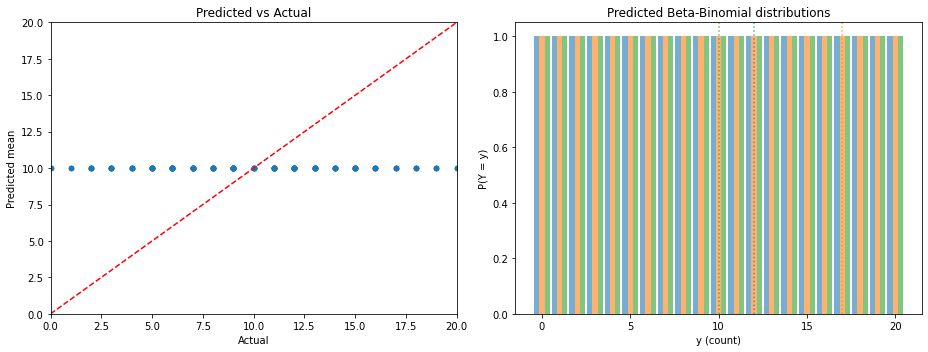

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Left: predictions vs actuals
ax = axes[0]
ax.scatter(Y_test, Y_pred, alpha=0.5, s=20)
lims = [0, N_TRIALS]
ax.plot(lims, lims, "r--")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted mean")
ax.set_title("Predicted vs Actual")
ax.set_xlim(lims)
ax.set_ylim(lims)

# Right: predicted Beta-Binomial PMFs for 3 test samples
ax = axes[1]
k = np.arange(0, N_TRIALS + 1)
for idx in [0, 50, 100]:
    a_i, b_i = dists.alpha[idx], dists.beta[idx]
    # Beta-Binomial PMF via scipy
    pmf = scipy.stats.betabinom.pmf(k, N_TRIALS, a_i, b_i)
    ax.bar(k + 0.3 * [0, 50, 100].index(idx) - 0.3, pmf, width=0.3, alpha=0.6,
           label=f"sample {idx} (a={a_i:.1f}, b={b_i:.1f})")
    ax.axvline(Y_test[idx], color=f"C{[0, 50, 100].index(idx)}",
               linestyle=":", alpha=0.7)
ax.set_xlabel("y (count)")
ax.set_ylabel("P(Y = y)")
ax.set_title("Predicted Beta-Binomial distributions")
# ax.legend()

plt.tight_layout()
plt.show()

## Note: the extra parameter pattern

The key pattern here is `extra_params=[n]` in `make_sympy_log_score`. This
tells the factory that `n` appears in the score expression but should **not**
be differentiated — it's a fixed constant per dataset. At runtime, the score
class reads `self.n` from the distribution instance.

To use different `n` values, create a subclass:

```python
class BetaBinomial50(BetaBinomial):
    def __init__(self, params):
        super().__init__(params, n=50)
    def fit(Y):
        return BetaBinomial.fit(Y, n=50)
```